<a id='header'></a>
# Demo for data manipulation

In this notebook we present *data manipulation* functionalities of the `preprocess` module.

- [**Section 1**](#centering_and_scaling):
- [**Section 2**](#outlier_detection):

***

**Should plots be saved?**

In [ ]:
save_plots = False

***

In [2]:
from PCAfold import preprocess
from PCAfold import PreProcessing
from PCAfold import reduction
import numpy as np

save_filename = None

***
<a id='centering_and_scaling'></a>
## Centering and scaling

[**Go up**](#header)

***
<a id='outlier_detection'></a>
## Multivariate outlier detection

[**Go up**](#header)

Genrate a two-dimensional data set with artificial outliers:

In [3]:
N = 2000
mean = [3, 3]
covariance = [[1, 0.2], [0.2, 1]]
x_data, y_data = np.random.multivariate_normal(mean, covariance, N).T
x_data = x_data[:,np.newaxis]
y_data = y_data[:,np.newaxis]

N_outliers = 20
mean_outliers = [7, 10]
covariance_outliers = [[0.2, .1], [.1, 0.2]]
x_outliers, y_outliers = np.random.multivariate_normal(mean_outliers, covariance_outliers, N_outliers).T

idx = np.zeros((N+N_outliers,))
x = np.vstack((x_data, x_outliers[:,np.newaxis]))
y = np.vstack((y_data, y_outliers[:,np.newaxis]))
X = np.hstack((x, y))

Visualize the data set and outliers using the `preprocess.plot_2d_clustering` function. Cluster `"0"` will be the data set and cluster `"1"` will be the outliers:

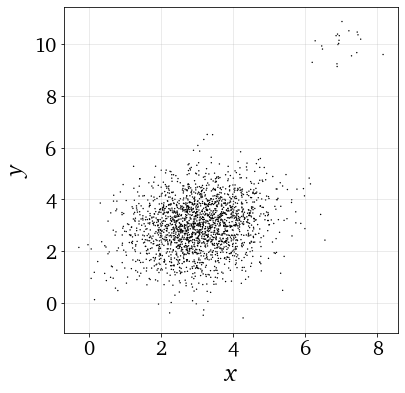

In [4]:
if save_plots: save_filename = '../images/data-manipulation-initial-data'
plt = reduction.plot_2d_manifold(X, color_variable='k', x_label='$x$', y_label='$y$', colorbar_label=None, title=None, save_filename=save_filename)

### Find multivariate outliers using `MULTIVARIATE TRIMMING` option

In [5]:
(idx_outliers_removed, idx_outliers) = preprocess.outlier_detection(X, scaling='auto', detection_method='MULTIVARIATE TRIMMING', trimming_fraction=0.6, n_iterations=0, verbose=True)

Number of observations classified as outliers: 20


We are going to visualize how the algorithm classified the data into outliers/not-outliers. We begin by generating the new cluster classification vector, where the cluster "0" will be non-outliers and cluster "1" will be outliers:

In [6]:
n_observations = N + N_outliers
idx_new = np.zeros((n_observations,))
for i in range(0, n_observations):
    if i in idx_outliers:
        idx_new[i] = 1

We can plot the partitioning:

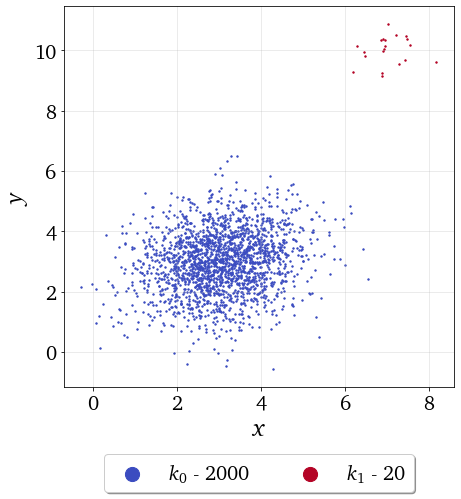

In [7]:
if save_plots: save_filename = '../images/data-manipulation-outliers-multivariate-trimming-60'
plt = preprocess.plot_2d_clustering(x, y, idx_new, x_label='$x$', y_label='$y$', color_map='coolwarm', first_cluster_index_zero=True, grid_on=True, figure_size=(7, 7), title=None, save_filename=save_filename)

If the parameter `trimming_fraction` is decreased, we more points that are within the data cloud become classified as outliers:

In [8]:
(idx_outliers_removed, idx_outliers) = preprocess.outlier_detection(X, scaling='auto', detection_method='MULTIVARIATE TRIMMING', trimming_fraction=0.3, n_iterations=0, verbose=True)

Number of observations classified as outliers: 180


In [9]:
n_observations = N + N_outliers
idx_new = np.zeros((n_observations,))
for i in range(0, n_observations):
    if i in idx_outliers:
        idx_new[i] = 1

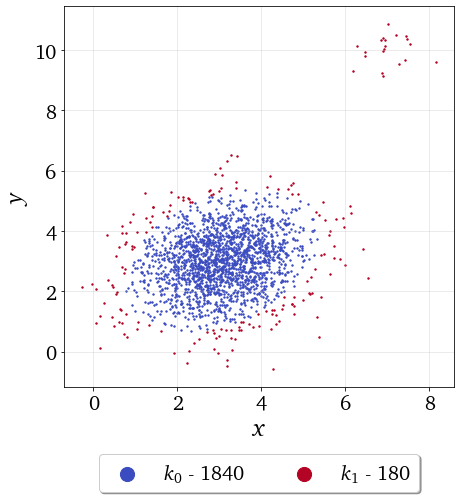

In [10]:
if save_plots: save_filename = '../images/data-manipulation-outliers-multivariate-trimming-30'
plt = preprocess.plot_2d_clustering(x, y, idx_new, x_label='$x$', y_label='$y$', color_map='coolwarm', first_cluster_index_zero=True, grid_on=True, figure_size=(7, 7), title=None, save_filename=save_filename)